In [53]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import yfinance as yf

from lstm_functions import *
from lost_functions import *

# Reading and storing the Data

In [20]:
raw_data = {}
stock_list = ["XOM", "SHW", "UPS", "DUK", "UNH", "JPM", "AMZN", "AAPL", "MSFT", "AMT"]
feature_list = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

for stock in stock_list:
    s = pd.read_excel('data_for_testing.xlsx', sheet_name=stock).set_index('Date')
    s = s.drop(columns=['Sector', 'Ticker'])
    # monthly_data = data.resample('M').last().reset_index()
    raw_data[stock] = s[-5001:]  # all stocks starting day diff, META don't even have 5000 trading days

raw_data

{'XOM':                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2003-10-31   36.450001   36.820000   36.439999   36.580002   19.054131   
 2003-11-03   36.919998   36.990002   36.549999   36.680000   19.106218   
 2003-11-04   36.520000   36.700001   36.200001   36.320000   18.918699   
 2003-11-05   36.240002   36.369999   35.930000   36.029999   18.767649   
 2003-11-06   35.900002   36.049999   35.750000   35.919998   18.710344   
 ...                ...         ...         ...         ...         ...   
 2023-09-08  114.529999  116.050003  114.320000  115.610001  115.610001   
 2023-09-11  116.180000  116.680000  113.570000  114.160004  114.160004   
 2023-09-12  115.339996  117.669998  115.269997  117.489998  117.489998   
 2023-09-13  117.410004  117.959999  115.900002  116.440002  116.440002   
 2023-09-14  117.550003  118.660004  117.320000  118.345001  118.345001   
 
               V

generating weights for y_true

In [21]:
### question: not possible to normalise to (-1, 1) and sum to 0, need solve optimisation problem?

price_data = pd.concat([raw_data[i]['Adj Close'] for i in stock_list], axis=1)
price_data.columns = stock_list

## get the % returns
returns_data = price_data.pct_change().iloc[1:, :] 

## normalize weights to (0, 1)
sc = MinMaxScaler(feature_range = (0, 1))
weights_data = pd.DataFrame(sc.fit_transform(returns_data.T).T)

## Sum weights to 1
weights_data['total'] = weights_data.sum(axis=1)
for col in weights_data.columns:
    weights_data[col] = weights_data[col]/weights_data['total']
weights_data = weights_data.drop(columns=['total'])
weights_array = weights_data.values

weights_data.head()

,0,1,2,3,4,5,6,7,8,9
0,0.054346,0.030718,0.027093,0.072245,0.000000,0.145867,0.237612,0.094158,0.137076,0.200886
1,0.105334,0.155936,0.152311,0.058699,0.087377,0.130517,0.149395,0.103290,0.057141,0.000000
2,0.018659,0.054200,0.093944,0.000000,0.194072,0.092490,0.090084,0.179449,0.129738,0.147364
3,0.109742,0.125343,0.150723,0.119567,0.050717,0.098018,0.000000,0.137230,0.141470,0.067189
4,0.119242,0.127229,0.151276,0.114842,0.006816,0.097372,0.072601,0.000000,0.109832,0.200790


data preprocessing

In [22]:
## compress into 3x6 features

data = pd.concat([raw_data[i] for i in stock_list], axis=1)[1:]
data.head()

,Open,High,Low,Close,Adj Close,Volume,Open,High,Low,Close,...,Low,Close,Adj Close,Volume,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,,,
2003-11-03,36.919998,36.990002,36.549999,36.680000,19.106218,11876500,11.206667,11.226667,11.153333,11.153333,...,26.290001,26.68,16.720776,57772300,11.60,12.00,11.60,12.00,9.559611,1348000
2003-11-04,36.520000,36.700001,36.200001,36.320000,18.918699,15295300,11.156667,11.256667,11.133333,11.196667,...,26.010000,26.07,16.338490,84026100,12.00,12.00,11.40,11.54,9.193154,1680800
2003-11-05,36.240002,36.369999,35.930000,36.029999,18.767649,12435800,11.166667,11.193333,11.033333,11.140000,...,26.000000,26.10,16.357286,61514400,11.64,11.64,11.31,11.57,9.217056,1149800
2003-11-06,35.900002,36.049999,35.750000,35.919998,18.710344,12125600,11.123333,11.166667,11.023333,11.150000,...,26.000000,26.23,16.438759,68189800,11.70,11.70,11.28,11.41,9.089595,897400
2003-11-07,35.900002,35.930000,35.490002,35.560001,18.652653,13687500,11.176667,11.210000,11.090000,11.133333,...,26.030001,26.10,16.357286,57822100,11.40,11.72,11.35,11.56,9.209090,719100


In [23]:
train_size = int(len(data) * 0.8)
sc = MinMaxScaler(feature_range = (0, 1))

weights_array_train = weights_array[:train_size]
weights_array_test = weights_array[train_size:]

train_data = data.iloc[:train_size]
train_array = train_data.values
train_scaled = sc.fit_transform(train_array)

test_data = data.iloc[train_size:]
test_array = test_data.values
test_scaled = sc.fit_transform(test_array)

train, test = np.array(train_scaled), np.array(test_scaled)
print(train.shape)
print(test.shape)

## table containing prices of test set (for portfolio evaluation)
test_prices = price_data[train_size:].copy(deep=True)
test_prices = test_prices[31:]  ## batch_size=30 and first value of y is 0 due to pct_change diff

(4000, 60)
(1000, 60)


data structure creation

In [24]:
batch_size = 30

x_train, y_train = [], []
x_test, y_test = [], []

for i in range(batch_size, train.shape[0]):
    x_train.append(train[i-batch_size: i, :])
    y_train.append(weights_array_train[i, :])

for i in range(batch_size, test.shape[0]):
    x_test.append(test[i-batch_size: i, :])
    y_test.append(weights_array_test[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3970, 30, 60) (3970, 10)
(970, 30, 60) (970, 10)
[[0.         0.1758119  0.11597898 ... 0.09766438 0.08367463 0.13763746]
 [0.21173349 0.00631245 0.15508884 ... 0.14795732 0.08134711 0.        ]
 [0.03325978 0.17408098 0.12350323 ... 0.11000218 0.14195667 0.10342506]
 ...
 [0.25909264 0.04103055 0.         ... 0.04527843 0.03974198 0.09622048]
 [0.02272233 0.07329581 0.1314184  ... 0.00411849 0.16214566 0.        ]
 [0.13696859 0.         0.1201738  ... 0.0780078  0.08657878 0.17990211]]


model initiation

In [37]:
num_units = [50, 40, 40, 40]

model = Sequential()

## can comment out FC layers too, but change first LSTM 2nd input to x_train.shape[2]
model.add(Dense(units=num_units[0], activation='swish', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(units=num_units[1], activation='swish'))
model.add(Dense(units=num_units[2], activation='swish'))
model.add(Dense(units=num_units[3], activation='swish'))

model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], num_units[3])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=30, activation='relu', return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))

model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 30, 50)            3050      
                                                                 
 dense_11 (Dense)            (None, 30, 40)            2040      
                                                                 
 dense_12 (Dense)            (None, 30, 40)            1640      
                                                                 
 dense_13 (Dense)            (None, 30, 40)            1640      
                                                                 
 lstm_8 (LSTM)               (None, 30, 30)            8520      
                                                                 
 dropout_8 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 30)           

In [47]:
model.compile(optimizer='adam', loss='mean_absolute_error')
model.fit(x=x_train, y=y_train, batch_size=64, epochs=10)

Epoch 1/10
63/63 [==============================] - 4s 25ms/step - loss: 0.0588
Epoch 2/10
63/63 [==============================] - 2s 27ms/step - loss: 0.0576
Epoch 3/10
63/63 [==============================] - 2s 30ms/step - loss: 0.0570
Epoch 4/10
63/63 [==============================] - 2s 30ms/step - loss: 0.0565
Epoch 5/10
63/63 [==============================] - 2s 30ms/step - loss: 0.0560
Epoch 6/10
63/63 [==============================] - 2s 30ms/step - loss: 0.0558
Epoch 7/10
63/63 [==============================] - 2s 30ms/step - loss: 0.0554
Epoch 8/10
63/63 [==============================] - 2s 30ms/step - loss: 0.0553
Epoch 9/10
63/63 [==============================] - 2s 30ms/step - loss: 0.0552
Epoch 10/10
63/63 [==============================] - 2s 30ms/step - loss: 0.0551


In [56]:
from tensorflow.keras.optimizers import Adam

# Tuning parameters 
param_space = {
    'units_lstm': [20, 30, 40, 50],
    'units_fc1': [10, 20, 30, 40],
    'units_fc2': [10, 20, 30, 40],
    'units_fc3': [10, 20, 30, 40],
    'epochs': [10, 20, 30],
    'batch_size': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.1, 0.2, 0.3]
}

# Number of random configurations to try
num_configs = 10
best_loss = float('inf')
best_hyperparameters = {}

for _ in range(num_configs):
    # Randomly sample hyperparameters from the search space
    hyperparameters = {param: random.choice(values) for param, values in param_space.items()}

    # Build the model with the current hyperparameters
    model = Sequential()
    model.add(Dense(units=hyperparameters['units_lstm'], activation='swish'))
    # Adding Dense layers
    for i in range(3):
        units = hyperparameters[f'units_fc{i+1}']
        model.add(Dense(units=units, activation='swish'))
    
    # Adding LSTM layers
    for i in range(4):
        units = hyperparameters['units_lstm']
        model.add(LSTM(units=units, activation='relu', return_sequences=True if i < 3 else False))
        model.add(Dropout(rate=hyperparameters['dropout_rate']))

    # Adding output Dense layer
    model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hyperparameters['learning_rate']), loss='mean_absolute_error')

    # Train the model
    history = model.fit(x=x_train, y=y_train, batch_size=hyperparameters['batch_size'],
                        epochs=hyperparameters['epochs'], verbose=0)

    # Evaluate the model
    val_loss = model.evaluate(x_test, y_test, verbose=0)

    # Check if this set of hyperparameters improved the model
    if val_loss < best_loss:
        best_loss = val_loss
        best_hyperparameters = hyperparameters

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters)

# Train the final model with the best hyperparameters
final_model = Sequential()

# Adding Dense layers
model.add(Dense(units=hyperparameters['units_lstm'], activation='swish'))
for i in range(4):
    units = best_hyperparameters[f'units_fc{i}']
    final_model.add(Dense(units=units, activation='swish'))

# Adding LSTM layers
for i in range(4):
    units = best_hyperparameters['units_lstm']
    final_model.add(LSTM(units=units, activation='relu', return_sequences=True if i < 3 else False))
    final_model.add(Dropout(rate=best_hyperparameters['dropout_rate']))

# Adding output Dense layer
final_model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

final_model.compile(optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']), loss='mean_absolute_error')
final_model.fit(x=x_train, y=y_train, batch_size=best_hyperparameters['batch_size'], epochs=best_hyperparameters['epochs'])

Best Hyperparameters:
{'units_lstm': 50, 'units_fc1': 20, 'units_fc2': 10, 'units_fc3': 30, 'epochs': 20, 'batch_size': 32, 'learning_rate': 0.001, 'dropout_rate': 0.2}


KeyError: 'units_fc4'

![Alt text](image-2.png)

model prediction

In [48]:
y_pred = model.predict(x_test)

31/31 [==============================] - 0s 5ms/step


In [40]:
print(y_pred.shape)
print(y_test.shape)

(970, 10)
(970, 10)


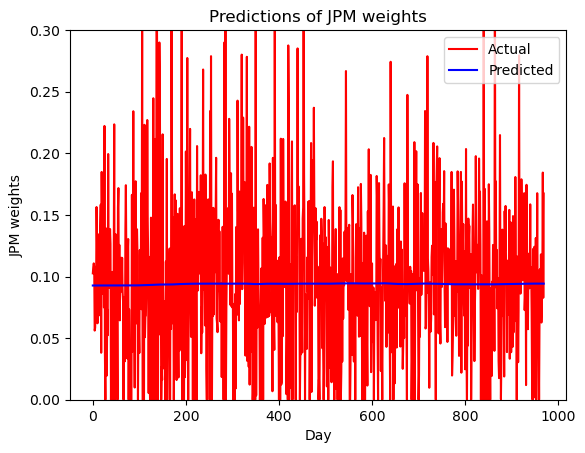

In [49]:
stock = 'JPM'             # XOM, SHW, UPS, DUK, UNH, JPM, AMZN, AAPL, MSFT, AMT
col = stock_list.index(stock)

plt.plot(y_test[:, col], color='red', label='Actual')
plt.plot(y_pred[:, col], color='blue', label='Predicted')
plt.title(f'Predictions of {stock} weights')
plt.xlabel('Day')
plt.ylabel(f'{stock} weights')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [42]:
print(f'y_pred: {y_pred[0]}')
print(f'y_test: {y_test[0]}')

y_pred: [0.09226365 0.0977018  0.09322899 0.08974759 0.0987144  0.09030107
 0.09894495 0.09910063 0.09504113 0.09710123]
y_test: [0.         0.1758119  0.11597898 0.10565713 0.09963861 0.10257159
 0.08136533 0.09766438 0.08367463 0.13763746]


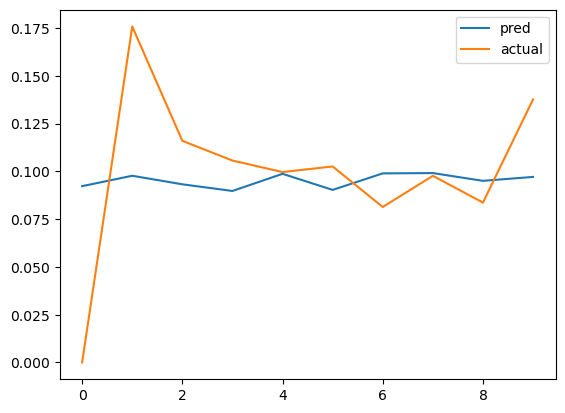

In [43]:
plt.plot(y_pred[0], label='pred')
plt.plot(y_test[0], label='actual')
plt.legend()
plt.show()

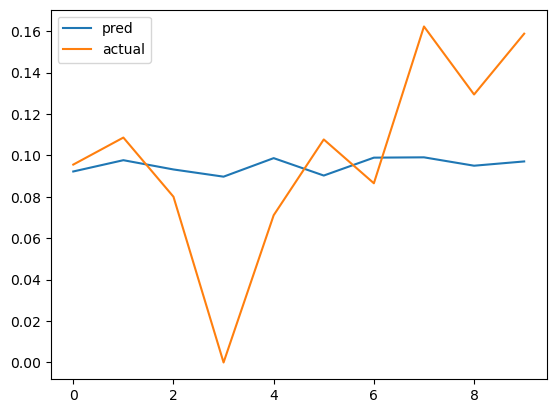

In [44]:
plt.plot(y_pred[3], label='pred')
plt.plot(y_test[3], label='actual')
plt.legend()
plt.show()

generate table of stock weights

In [50]:
weights_pred = pd.DataFrame(y_pred)
weights_pred.columns = stock_list
weights_pred.index = test_prices.index.copy()
weights_pred.head()

,XOM,SHW,UPS,DUK,UNH,JPM,AMZN,AAPL,MSFT,AMT
Date,,,,,,,,,,
2019-11-06,0.094811,0.098455,0.095327,0.094964,0.100795,0.092705,0.098121,0.099647,0.096589,0.097926
2019-11-07,0.094813,0.098458,0.095329,0.094967,0.100797,0.092707,0.098123,0.099649,0.096592,0.097929
2019-11-08,0.094814,0.098459,0.095330,0.094968,0.100797,0.092708,0.098123,0.099649,0.096594,0.097930
2019-11-11,0.094816,0.098463,0.095334,0.094972,0.100800,0.092710,0.098125,0.099651,0.096598,0.097934
2019-11-12,0.094819,0.098467,0.095338,0.094976,0.100803,0.092713,0.098128,0.099654,0.096602,0.097938


portfolio evaluation

Annualized Return: 16.81%
Annualized Volatility: 22.69%
Sharpe Ratio: 0.61
Maximum Drawdown: -30.04%


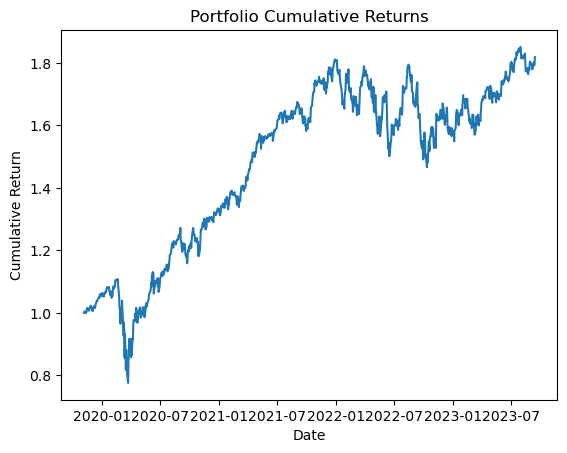

In [51]:
def backtest(test_df, weights):
    '''
    df of stocks with index being date, cols being stocks, each entry being the price 
    weights represent the normalized portfolio weights
    '''
    returns = test_df.pct_change().dropna()

    portfolio_returns = (returns * weights).sum(axis=1)

    cumulative_returns = (1 + portfolio_returns).cumprod()

    annualized_return = (cumulative_returns[-1])**(252/len(cumulative_returns.index)) - 1  # Assuming 252 trading days
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)

    # Calculate Sharpe Ratio
    risk_free_rate = 0.03 # can change 
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate Maximum Drawdown
    cumulative_returns_index = (1 + portfolio_returns).cumprod()
    cumulative_max = cumulative_returns_index.cummax()
    drawdown = (cumulative_returns_index - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")


    plt.plot(cumulative_returns)
    plt.title('Portfolio Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()

backtest(test_prices, weights_pred)

In [35]:
def custom_loss_1(y_true, y_pred):
    # y_true is the s&p500 returns
    # y_pred is the array of weights for each stock
    # we want to maximise y_pred - s&p500 returns (at least 20% higher)
    # aka minimise s&p500 returns - y_pred

    # <normalize>
    # predicted weights for day i * returns on day i = total returns
    # compare w s&p500 returns

    return y_true*1.2 - y_pred

In [36]:
# Loop through each stock data
for ticker, data in all_data.items():
    
    # Drop non-numeric columns
    data = data.drop(columns=['Sector', 'Ticker', 'Date'])  # Assuming 'Date' is the index
    lstm_model = LstmBuilder(time_step=time_steps, loss=huber_loss)
    model = lstm_model.create_model(features=features)
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    X, y = lstm_model.create_sequences(normalized_data)
    X_train, X_test, y_train, y_test = lstm_model.split_data(X,y)
    
    print("Working on: " + ticker)  
    model.fit(X_train, y_train, epochs=3, batch_size=4, validation_split=0.2, verbose=0)
    '''
    Batch Size: Refers to the number of training examples utilized in one iteration. When you set batch_size=32, it means the model takes 32 sequences at a time and updates weights once after computing the loss of the entire batch.
    Input Shape (60, 6): Refers to the shape of a single input sequence.
    60 indicates the number of time steps in each sequence. In your case, each sequence contains data from 60 days.
    6 refers to the number of features ('Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume').
    So, when you train your LSTM, it takes in 32 sequences (if we consider batch_size=32) at a time, and each of those sequences contains 60 time steps with 6 features for each time step.

    In simpler terms:

    Input Shape: Shape of a single sequence that you feed into the model.
    Batch Size: Number of sequences you feed into the model at one go.
    These two are different parameters and have different roles in the training process. The batch size is related to how you update the weights during training, whereas the input shape is related to the structure and size of your input data.
    '''
    
    # Predict the next day value
    last_days = normalized_data[-time_steps:].reshape(1, time_steps, features)
    prediction_next_day = model.predict(last_days)
    prediction_next_day_actual = scaler.inverse_transform(prediction_next_day)
    final_predictions[ticker] = prediction_next_day_actual.flatten()
    print(f"Predicted value for {ticker}: {prediction_next_day_actual.flatten()}")

    
    # Extracting importance
    dense_weights = model.layers[-1].get_weights()[0]

    # Think about to use sum or mean and to use abs() or not
    feature_weights = dense_weights.sum(axis=0)
    weighted_importance = prediction_next_day.flatten() * feature_weights
    final_importance_value = np.sum(weighted_importance)  # Final importance as a single value
    print(f"Importance value for {ticker}: {final_importance_value}")
    
    # Store the importance value in the dictionary
    final_importance_values[ticker] = final_importance_value

print(final_importance_values)

NameError: name 'all_data' is not defined

In [ ]:
final_importance_values

: 

In [ ]:
importance_values = np.array(list(final_importance_values.values()))

: 

# Run this if we want a arbitrage strategy
Each weight will be -1 to 1, the sum is 0

In [ ]:
## testing his normalization code

importance_values = [-24.02027, 5.5614214, 5.2308617, -5.3437276, 0.14171359, 100]

arbitrage_scaled_importance = 2 * (importance_values - np.min(importance_values)) / (np.max(importance_values) - np.min(importance_values)) - 1

# 2. Ensure the sum is zero
arbitrage_normalized_importance = arbitrage_scaled_importance - np.mean(arbitrage_scaled_importance)

arbitrage_normalized_importance


: 

In [ ]:
# 1. Scale the values to [-1, 1]
arbitrage_scaled_importance = 2 * (importance_values - np.min(importance_values)) / (np.max(importance_values) - np.min(importance_values)) - 1

# 2. Ensure the sum is zero
arbitrage_normalized_importance = arbitrage_scaled_importance - np.mean(arbitrage_scaled_importance)

# Convert back to dictionary
arbitrage_ticker_to_importance = dict(zip(final_importance_values.keys(), arbitrage_normalized_importance))

print(arbitrage_ticker_to_importance)

: 

# Run this instead if we want a normal strategy
Each weight will be 0 to 1, the sum is 1

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))  # subtract max to avoid potential overflow
    return e_x / e_x.sum(axis=0)

# Convert the importance values to probabilities using softmax
probabilities = softmax(importance_values)

# Convert back to dictionary
normalized_ticker_to_importance = dict(zip(final_importance_values.keys(), probabilities))

print(normalized_ticker_to_importance)

: 

In [ ]:
def plot_importance(normalized_ticker_to_importance = normalized_ticker_to_importance, title='Normalized Importance Values'):
# Split the tickers and importance values based on positive and negative values
    long_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v > 0}
    short_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v <= 0}

    # Sort the positions for better visualization
    sorted_long = dict(sorted(long_positions.items(), key=lambda item: item[1], reverse=True))
    sorted_short = dict(sorted(short_positions.items(), key=lambda item: item[1]))

    # Create bar charts
    fig, ax = plt.subplots(figsize=(12, 7))

    # Positive cluster
    bars_long = ax.bar(sorted_long.keys(), sorted_long.values(), color='g', label='Long')

    # Negative cluster
    bars_short = ax.bar(sorted_short.keys(), sorted_short.values(), color='r', label='Short')

    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Annotate the bars
    for bar in bars_long:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=9)

    for bar in bars_short:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval - 0.02, round(yval, 3), ha='center', va='top', fontsize=9)

    ax.set_title(title)
    ax.set_ylabel('Importance Value')
    ax.set_xlabel('Ticker')
    ax.legend()

    plt.tight_layout()
    plt.show()


: 

In [ ]:
# Plot the arbitrage importance values
plot_importance(arbitrage_ticker_to_importance, title='Arbitrage Importance Values')

: 

In [ ]:
# Plot the importance values
plot_importance(normalized_ticker_to_importance, title='Normalized Importance Values')

: 

In [ ]:
spy_data = yf.download('SPY')
spy_monthly = spy_data.resample('M').last()
spy_monthly

: 

In [ ]:
all_data

: 

In [ ]:
# Construct the Portfolio and Backtest
def build_portfolio(normalized_ticker_to_importance=normalized_ticker_to_importance, strategy='Normal'):
    portfolio_returns = pd.DataFrame()
    for ticker, importance in normalized_ticker_to_importance.items():
        data = all_data[ticker].set_index('Date')
        data['Returns'] = data['Adj Close'].pct_change().fillna(0)
        portfolio_returns[ticker] = data['Returns'] * importance
    portfolio_returns['Portfolio'] = portfolio_returns.sum(axis=1)
    spy_monthly['SPY Returns'] = spy_monthly['Adj Close'].pct_change().fillna(0)
    # Cumulative Returns
    portfolio_returns['Cumulative Portfolio'] = (portfolio_returns['Portfolio'] + 1).cumprod() - 1
    spy_monthly['Cumulative SPY'] = (spy_monthly['SPY Returns'] + 1).cumprod() - 1
    combined = pd.concat([portfolio_returns['Cumulative Portfolio'], spy_monthly['Cumulative SPY']], axis=1).dropna()
    print(combined)
    # Plot
    plt.figure(figsize=(14,7))
    combined['Cumulative Portfolio'].plot(label="Portfolio")
    combined['Cumulative SPY'].plot(label="SPY")
    plt.legend()
    plt.title(strategy + " Portfolio vs. SPY Cumulative Returns")
    plt.show()


: 

In [ ]:
# Build the portfolio for arbitrage strategy
build_portfolio(arbitrage_ticker_to_importance, strategy='Arbitrage')

: 

In [ ]:
# Build the portfolio for the Normal strategy
build_portfolio(normalized_ticker_to_importance, strategy='Normal')

: 